In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(364416, 828)
(364416, 1)
validation
(50712, 828)
(50712, 1)
test
(49296, 828)
(49296, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 44s - loss: 0.0443 - STD: 9.4673e-05 - MAE: 0.2015

 4/37 [==>...........................] - ETA: 6s - loss: 0.0280 - STD: 2.0914e-04 - MAE: 0.1258 

 8/37 [=====>........................] - ETA: 3s - loss: 0.0248 - STD: 2.2005e-04 - MAE: 0.1105

 9/37 [======>.......................] - ETA: 2s - loss: 0.0235 - STD: 2.4448e-04 - MAE: 0.1069

10/37 [=======>......................] - ETA: 2s - loss: 0.0226 - STD: 2.7222e-04 - MAE: 0.1062

11/37 [=======>......................] - ETA: 2s - loss: 0.0222 - STD: 2.9999e-04 - MAE: 0.1074

12/37 [========>.....................] - ETA: 2s - loss: 0.0219 - STD: 3.2737e-04 - MAE: 0.1086

13/37 [=========>....................] - ETA: 2s - loss: 0.0215 - STD: 3.5238e-04 - MAE: 0.1091

14/37 [==========>...................] - ETA: 2s - loss: 0.0210 - STD: 3.7471e-04 - MAE: 0.1084

15/37 [===========>..................] - ETA: 2s - loss: 0.0205 - STD: 3.9381e-04 - MAE: 0.1067

16/37 [===========>..................] - ETA: 2s - loss: 0.0201 - STD: 4.1021e-04 - MAE: 0.1045

17/37 [============>.................] - ETA: 1s - loss: 0.0197 - STD: 4.2421e-04 - MAE: 0.1022

18/37 [=============>................] - ETA: 1s - loss: 0.0194 - STD: 4.3664e-04 - MAE: 0.1001

19/37 [==============>...............] - ETA: 1s - loss: 0.0192 - STD: 4.4811e-04 - MAE: 0.0981

20/37 [===============>..............] - ETA: 1s - loss: 0.0190 - STD: 4.5985e-04 - MAE: 0.0966

21/37 [================>.............] - ETA: 1s - loss: 0.0188 - STD: 4.7280e-04 - MAE: 0.0950

22/37 [================>.............] - ETA: 1s - loss: 0.0186 - STD: 4.8742e-04 - MAE: 0.0936

23/37 [=================>............] - ETA: 1s - loss: 0.0183 - STD: 5.0314e-04 - MAE: 0.0923

24/37 [==================>...........] - ETA: 1s - loss: 0.0181 - STD: 5.2118e-04 - MAE: 0.0913

25/37 [===================>..........] - ETA: 1s - loss: 0.0179 - STD: 5.4114e-04 - MAE: 0.0907

26/37 [====================>.........] - ETA: 1s - loss: 0.0177 - STD: 5.6289e-04 - MAE: 0.0903

27/37 [====================>.........] - ETA: 0s - loss: 0.0176 - STD: 5.8577e-04 - MAE: 0.0903

28/37 [=====================>........] - ETA: 0s - loss: 0.0174 - STD: 6.0982e-04 - MAE: 0.0904

29/37 [======================>.......] - ETA: 0s - loss: 0.0173 - STD: 6.3368e-04 - MAE: 0.0904

30/37 [=======================>......] - ETA: 0s - loss: 0.0172 - STD: 6.5805e-04 - MAE: 0.0904

31/37 [========================>.....] - ETA: 0s - loss: 0.0171 - STD: 6.8205e-04 - MAE: 0.0901

32/37 [========================>.....] - ETA: 0s - loss: 0.0170 - STD: 7.0528e-04 - MAE: 0.0897

33/37 [=========================>....] - ETA: 0s - loss: 0.0168 - STD: 7.2842e-04 - MAE: 0.0891

34/37 [==========================>...] - ETA: 0s - loss: 0.0167 - STD: 7.5139e-04 - MAE: 0.0885

35/37 [===========================>..] - ETA: 0s - loss: 0.0166 - STD: 7.7477e-04 - MAE: 0.0878

36/37 [============================>.] - ETA: 0s - loss: 0.0165 - STD: 7.9904e-04 - MAE: 0.0872

37/37 [==============================] - ETA: 0s - loss: 0.0165 - STD: 8.2491e-04 - MAE: 0.0867

37/37 [==============================] - 5s 113ms/step - loss: 0.0165 - STD: 8.2491e-04 - MAE: 0.0867 - val_loss: 0.0141 - val_STD: 0.0014 - val_MAE: 0.0801


Epoch 2/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0132 - STD: 0.0019 - MAE: 0.0661

 2/37 [>.............................] - ETA: 3s - loss: 0.0132 - STD: 0.0019 - MAE: 0.0671

 3/37 [=>............................] - ETA: 3s - loss: 0.0132 - STD: 0.0020 - MAE: 0.0685

 4/37 [==>...........................] - ETA: 3s - loss: 0.0133 - STD: 0.0021 - MAE: 0.0701

 5/37 [===>..........................] - ETA: 3s - loss: 0.0133 - STD: 0.0022 - MAE: 0.0717

 6/37 [===>..........................] - ETA: 2s - loss: 0.0132 - STD: 0.0023 - MAE: 0.0730

 7/37 [====>.........................] - ETA: 2s - loss: 0.0132 - STD: 0.0024 - MAE: 0.0743

 8/37 [=====>........................] - ETA: 2s - loss: 0.0134 - STD: 0.0025 - MAE: 0.0754

 9/37 [======>.......................] - ETA: 2s - loss: 0.0133 - STD: 0.0026 - MAE: 0.0757

10/37 [=======>......................] - ETA: 2s - loss: 0.0133 - STD: 0.0027 - MAE: 0.0759

11/37 [=======>......................] - ETA: 2s - loss: 0.0132 - STD: 0.0028 - MAE: 0.0757

12/37 [========>.....................] - ETA: 2s - loss: 0.0131 - STD: 0.0029 - MAE: 0.0752

13/37 [=========>....................] - ETA: 2s - loss: 0.0131 - STD: 0.0030 - MAE: 0.0747

14/37 [==========>...................] - ETA: 2s - loss: 0.0130 - STD: 0.0031 - MAE: 0.0741

15/37 [===========>..................] - ETA: 2s - loss: 0.0130 - STD: 0.0032 - MAE: 0.0737

16/37 [===========>..................] - ETA: 1s - loss: 0.0130 - STD: 0.0034 - MAE: 0.0732

17/37 [============>.................] - ETA: 1s - loss: 0.0129 - STD: 0.0035 - MAE: 0.0729

18/37 [=============>................] - ETA: 1s - loss: 0.0129 - STD: 0.0037 - MAE: 0.0727

19/37 [==============>...............] - ETA: 1s - loss: 0.0129 - STD: 0.0038 - MAE: 0.0727

20/37 [===============>..............] - ETA: 1s - loss: 0.0129 - STD: 0.0040 - MAE: 0.0727

22/37 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 0.0045 - MAE: 0.0727

23/37 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 0.0047 - MAE: 0.0727

24/37 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 0.0050 - MAE: 0.0726

25/37 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 0.0052 - MAE: 0.0725

26/37 [====================>.........] - ETA: 1s - loss: 0.0126 - STD: 0.0055 - MAE: 0.0723

27/37 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 0.0058 - MAE: 0.0720

28/37 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 0.0062 - MAE: 0.0717

29/37 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 0.0066 - MAE: 0.0715

30/37 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 0.0070 - MAE: 0.0712

31/37 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 0.0074 - MAE: 0.0710

32/37 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 0.0079 - MAE: 0.0709

33/37 [=========================>....] - ETA: 0s - loss: 0.0122 - STD: 0.0085 - MAE: 0.0707

34/37 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 0.0091 - MAE: 0.0705

35/37 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 0.0097 - MAE: 0.0703

36/37 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 0.0104 - MAE: 0.0700

37/37 [==============================] - ETA: 0s - loss: 0.0119 - STD: 0.0111 - MAE: 0.0696

37/37 [==============================] - 4s 97ms/step - loss: 0.0119 - STD: 0.0111 - MAE: 0.0696 - val_loss: 0.0086 - val_STD: 0.0306 - val_MAE: 0.0627


Epoch 3/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0087 - STD: 0.0408 - MAE: 0.0563

 2/37 [>.............................] - ETA: 3s - loss: 0.0083 - STD: 0.0423 - MAE: 0.0550

 4/37 [==>...........................] - ETA: 2s - loss: 0.0079 - STD: 0.0470 - MAE: 0.0542

 5/37 [===>..........................] - ETA: 2s - loss: 0.0077 - STD: 0.0495 - MAE: 0.0540

 6/37 [===>..........................] - ETA: 2s - loss: 0.0074 - STD: 0.0517 - MAE: 0.0535

 7/37 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0538 - MAE: 0.0530

 8/37 [=====>........................] - ETA: 2s - loss: 0.0070 - STD: 0.0556 - MAE: 0.0524

 9/37 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0572 - MAE: 0.0518

10/37 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0591 - MAE: 0.0514

11/37 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0610 - MAE: 0.0508

12/37 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.0629 - MAE: 0.0504

13/37 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0647 - MAE: 0.0500

14/37 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0663 - MAE: 0.0495

15/37 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0677 - MAE: 0.0491

16/37 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0689 - MAE: 0.0487

17/37 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0702 - MAE: 0.0482

18/37 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0714 - MAE: 0.0478

19/37 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0474

20/37 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0736 - MAE: 0.0470

21/37 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0466

22/37 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0463

23/37 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0766 - MAE: 0.0460

24/37 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0776 - MAE: 0.0457

25/37 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0785 - MAE: 0.0454

26/37 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0791 - MAE: 0.0451

27/37 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0448

28/37 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0446

29/37 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0444

30/37 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0823 - MAE: 0.0441

31/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0830 - MAE: 0.0439

32/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0835 - MAE: 0.0437

33/37 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0839 - MAE: 0.0435

34/37 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0844 - MAE: 0.0433

35/37 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0848 - MAE: 0.0431

36/37 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0853 - MAE: 0.0429

37/37 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0858 - MAE: 0.0427

37/37 [==============================] - 4s 99ms/step - loss: 0.0044 - STD: 0.0858 - MAE: 0.0427 - val_loss: 0.0030 - val_STD: 0.0873 - val_MAE: 0.0342


Epoch 4/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0981 - MAE: 0.0359

 2/37 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.1008 - MAE: 0.0358

 3/37 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0359

 4/37 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0357

 5/37 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0356

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.1021 - MAE: 0.0355

 7/37 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1019 - MAE: 0.0355

 8/37 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0356

 9/37 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0357

10/37 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0357

11/37 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0356

12/37 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1023 - MAE: 0.0356

13/37 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1022 - MAE: 0.0356

14/37 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0356

15/37 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1022 - MAE: 0.0355

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1018 - MAE: 0.0355

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1018 - MAE: 0.0355

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1020 - MAE: 0.0355

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1021 - MAE: 0.0354

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1022 - MAE: 0.0354

21/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1022 - MAE: 0.0354

22/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1022 - MAE: 0.0353

24/37 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1024 - MAE: 0.0353

25/37 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1023 - MAE: 0.0352

26/37 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1023 - MAE: 0.0352

27/37 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1022 - MAE: 0.0351

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1023 - MAE: 0.0351

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1023 - MAE: 0.0351

30/37 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1023 - MAE: 0.0350

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1023 - MAE: 0.0350

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1022 - MAE: 0.0349

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1023 - MAE: 0.0349

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1022 - MAE: 0.0349

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1021 - MAE: 0.0348

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1021 - MAE: 0.0348

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1022 - MAE: 0.0348

37/37 [==============================] - 4s 99ms/step - loss: 0.0027 - STD: 0.1022 - MAE: 0.0348 - val_loss: 0.0030 - val_STD: 0.0863 - val_MAE: 0.0337


Epoch 5/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0333

 2/37 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0331

 3/37 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0331

 4/37 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0334

 5/37 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0334

 6/37 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0333

 7/37 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0332

 8/37 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1029 - MAE: 0.0333

 9/37 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1032 - MAE: 0.0332

10/37 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1030 - MAE: 0.0332

11/37 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1029 - MAE: 0.0332

12/37 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1028 - MAE: 0.0332

13/37 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1028 - MAE: 0.0332

14/37 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1029 - MAE: 0.0332

15/37 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1029 - MAE: 0.0331

16/37 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1030 - MAE: 0.0331

17/37 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1032 - MAE: 0.0331

18/37 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1033 - MAE: 0.0330

19/37 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1033 - MAE: 0.0330

20/37 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1033 - MAE: 0.0330

22/37 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1035 - MAE: 0.0330

23/37 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1034 - MAE: 0.0329

24/37 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0329

25/37 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0329

26/37 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0329

27/37 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1032 - MAE: 0.0329

28/37 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1033 - MAE: 0.0329

29/37 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0328

30/37 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0328

31/37 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0328

32/37 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0328

33/37 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0327

34/37 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0327

35/37 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0327

36/37 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1035 - MAE: 0.0327

37/37 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1035 - MAE: 0.0327

37/37 [==============================] - 4s 109ms/step - loss: 0.0024 - STD: 0.1035 - MAE: 0.0327 - val_loss: 0.0033 - val_STD: 0.0838 - val_MAE: 0.0337


Epoch 6/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1008 - MAE: 0.0314

 2/37 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0316

 3/37 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0317

 4/37 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0318

 5/37 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0317

 6/37 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0317

 7/37 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.1032 - MAE: 0.0316

 8/37 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1034 - MAE: 0.0316

 9/37 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1033 - MAE: 0.0316

10/37 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1039 - MAE: 0.0318

11/37 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1039 - MAE: 0.0318

12/37 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1037 - MAE: 0.0318

13/37 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1037 - MAE: 0.0318

14/37 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1036 - MAE: 0.0317

15/37 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1035 - MAE: 0.0317

16/37 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1035 - MAE: 0.0317

17/37 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.1038 - MAE: 0.0318

18/37 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1036 - MAE: 0.0318

19/37 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1037 - MAE: 0.0318

20/37 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1040 - MAE: 0.0317

21/37 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1041 - MAE: 0.0317

23/37 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1039 - MAE: 0.0317

24/37 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1039 - MAE: 0.0317

25/37 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1038 - MAE: 0.0317

26/37 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1038 - MAE: 0.0316

27/37 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1037 - MAE: 0.0316

28/37 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1039 - MAE: 0.0315

29/37 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1040 - MAE: 0.0315

30/37 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1040 - MAE: 0.0315

31/37 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1042 - MAE: 0.0315

32/37 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1041 - MAE: 0.0314

33/37 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1040 - MAE: 0.0314

34/37 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1041 - MAE: 0.0314

35/37 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1040 - MAE: 0.0314

36/37 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1040 - MAE: 0.0313

37/37 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1041 - MAE: 0.0313

37/37 [==============================] - 4s 100ms/step - loss: 0.0022 - STD: 0.1041 - MAE: 0.0313 - val_loss: 0.0033 - val_STD: 0.0870 - val_MAE: 0.0331


Epoch 7/10000


 1/37 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0305

 2/37 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1078 - MAE: 0.0304

 3/37 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1086 - MAE: 0.0305

 4/37 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0304

 5/37 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0305

 6/37 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1057 - MAE: 0.0307

 7/37 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0306

 8/37 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1045 - MAE: 0.0306

 9/37 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.1049 - MAE: 0.0307

10/37 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0307

11/37 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.1050 - MAE: 0.0307

12/37 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1049 - MAE: 0.0307

13/37 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1048 - MAE: 0.0307

14/37 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1051 - MAE: 0.0307

15/37 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0307

16/37 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0306

17/37 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1054 - MAE: 0.0306

18/37 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1054 - MAE: 0.0306

19/37 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1053 - MAE: 0.0305

20/37 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0305

21/37 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0305

22/37 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0305

23/37 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0304

24/37 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0304

25/37 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0304

26/37 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0304

27/37 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0304

28/37 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0304

29/37 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0304

30/37 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0304

31/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0303

32/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0303

33/37 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0303

34/37 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1049 - MAE: 0.0303

35/37 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0303

36/37 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0302

37/37 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0302

37/37 [==============================] - 5s 128ms/step - loss: 0.0021 - STD: 0.1051 - MAE: 0.0302 - val_loss: 0.0031 - val_STD: 0.0884 - val_MAE: 0.0326


Epoch 8/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0299

 2/37 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1078 - MAE: 0.0299

 3/37 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0301

 4/37 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1048 - MAE: 0.0303

 5/37 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0301

 6/37 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0301

 7/37 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1055 - MAE: 0.0302

 8/37 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0300

 9/37 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0300

10/37 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0301

11/37 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0302

12/37 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0301

13/37 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0301

14/37 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.1055 - MAE: 0.0302

15/37 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0302

16/37 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1059 - MAE: 0.0303

17/37 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1054 - MAE: 0.0305

18/37 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1053 - MAE: 0.0305

19/37 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1054 - MAE: 0.0306

20/37 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0307

21/37 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0307

22/37 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0308

23/37 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1050 - MAE: 0.0309

24/37 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1048 - MAE: 0.0309

25/37 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0310

26/37 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1051 - MAE: 0.0309

27/37 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1049 - MAE: 0.0309

28/37 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1050 - MAE: 0.0310

29/37 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1051 - MAE: 0.0309

30/37 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1049 - MAE: 0.0309

31/37 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1048 - MAE: 0.0308

32/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0308

33/37 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0308

34/37 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1049 - MAE: 0.0308

35/37 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0307

36/37 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0307

37/37 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1050 - MAE: 0.0307

37/37 [==============================] - 5s 133ms/step - loss: 0.0021 - STD: 0.1050 - MAE: 0.0307 - val_loss: 0.0032 - val_STD: 0.0887 - val_MAE: 0.0323


Epoch 9/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1067 - MAE: 0.0291

 2/37 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1079 - MAE: 0.0297

 3/37 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1074 - MAE: 0.0295

 4/37 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1061 - MAE: 0.0295

 5/37 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1065 - MAE: 0.0296

 6/37 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1069 - MAE: 0.0297

 7/37 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.1059 - MAE: 0.0297

 8/37 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0297

 9/37 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0299

10/37 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0298

11/37 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0298

12/37 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0298

13/37 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1058 - MAE: 0.0299

15/37 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0298

16/37 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1059 - MAE: 0.0299

17/37 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1058 - MAE: 0.0298

18/37 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0298

19/37 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0297

20/37 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1053 - MAE: 0.0297

21/37 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1052 - MAE: 0.0297

22/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0296

23/37 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0296

24/37 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0296

25/37 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0295

26/37 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0295

27/37 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0295

28/37 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0295

29/37 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0295

30/37 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0295

31/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0294

32/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0294

33/37 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0294

34/37 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0294

35/37 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0294

36/37 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0294

37/37 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0294

37/37 [==============================] - 5s 136ms/step - loss: 0.0020 - STD: 0.1057 - MAE: 0.0294 - val_loss: 0.0033 - val_STD: 0.0880 - val_MAE: 0.0326


Epoch 10/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0287

 2/37 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0291

 3/37 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

 4/37 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1061 - MAE: 0.0291

 5/37 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1067 - MAE: 0.0291

 6/37 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1067 - MAE: 0.0291

 7/37 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1067 - MAE: 0.0290

 8/37 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1068 - MAE: 0.0290

 9/37 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0289

10/37 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0288

11/37 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0287

12/37 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0287

13/37 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0287

14/37 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0287

15/37 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0287

16/37 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0287

17/37 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0287

18/37 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0287

19/37 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0287

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0287

22/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0287

23/37 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0287

24/37 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0287

25/37 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0287

26/37 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0287

27/37 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0287

28/37 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0287

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0287

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0287

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0287

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0287

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0287

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0287

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0287

36/37 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0287

37/37 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0287

37/37 [==============================] - 4s 114ms/step - loss: 0.0019 - STD: 0.1061 - MAE: 0.0287 - val_loss: 0.0032 - val_STD: 0.0912 - val_MAE: 0.0329


Epoch 11/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

 2/37 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0283

 3/37 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0284

 4/37 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1059 - MAE: 0.0284

 5/37 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0284

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0284

 7/37 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0284

 8/37 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0283

 9/37 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0284

10/37 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0283

11/37 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0283

12/37 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0284

14/37 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0284

15/37 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0284

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0284

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0284

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0284

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0284

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0284

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0284

22/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0285

23/37 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0284

24/37 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0284

25/37 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0285

26/37 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0285

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0286

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0285

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0285

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0286

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0286

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0286

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0286

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0285

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0286

36/37 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0285

37/37 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0286

37/37 [==============================] - 4s 96ms/step - loss: 0.0019 - STD: 0.1066 - MAE: 0.0286 - val_loss: 0.0030 - val_STD: 0.0938 - val_MAE: 0.0326


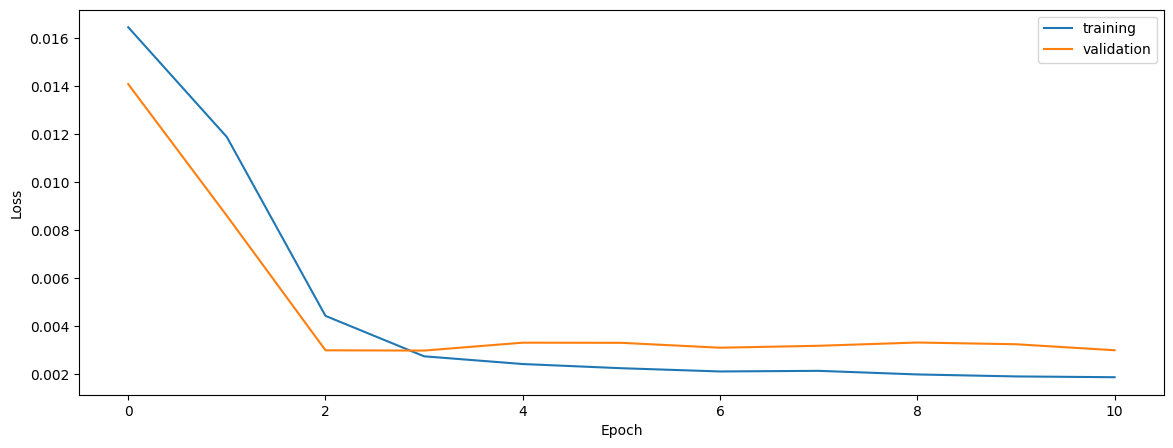

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9007579567018389
0.9021109843120441
0.920556105032386


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9007579567018389
0.9021109843120441
0.920556105032386


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.9167424482319644
0.9162148905438721
0.9364796369074722


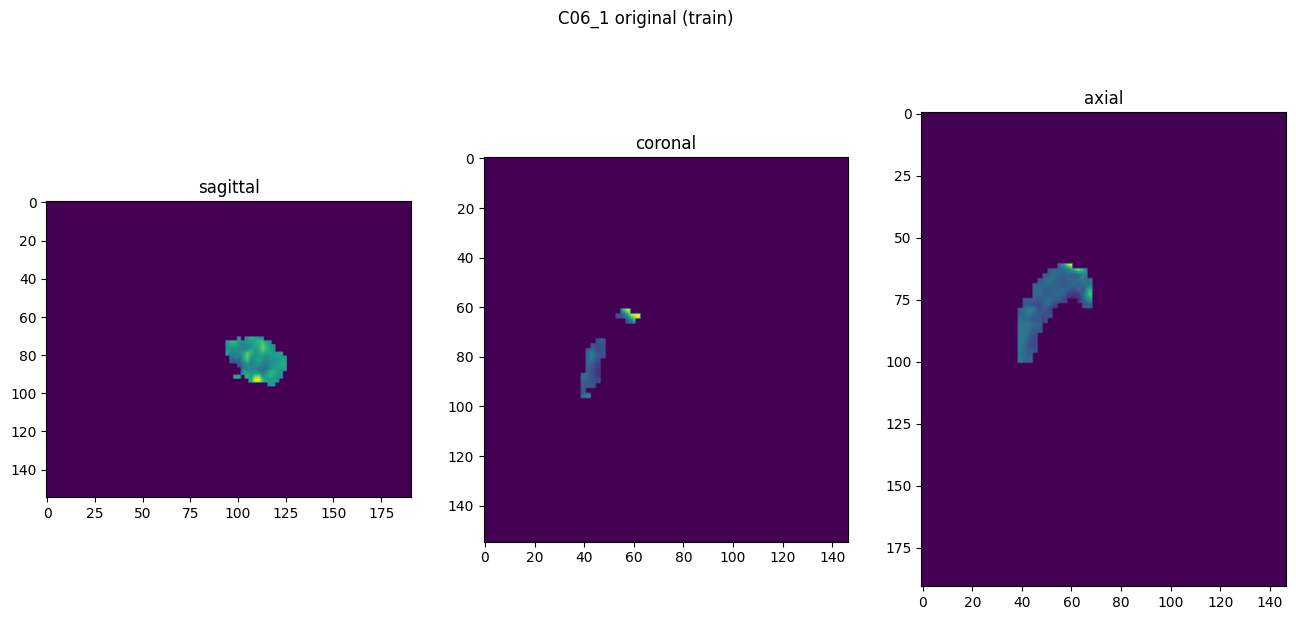

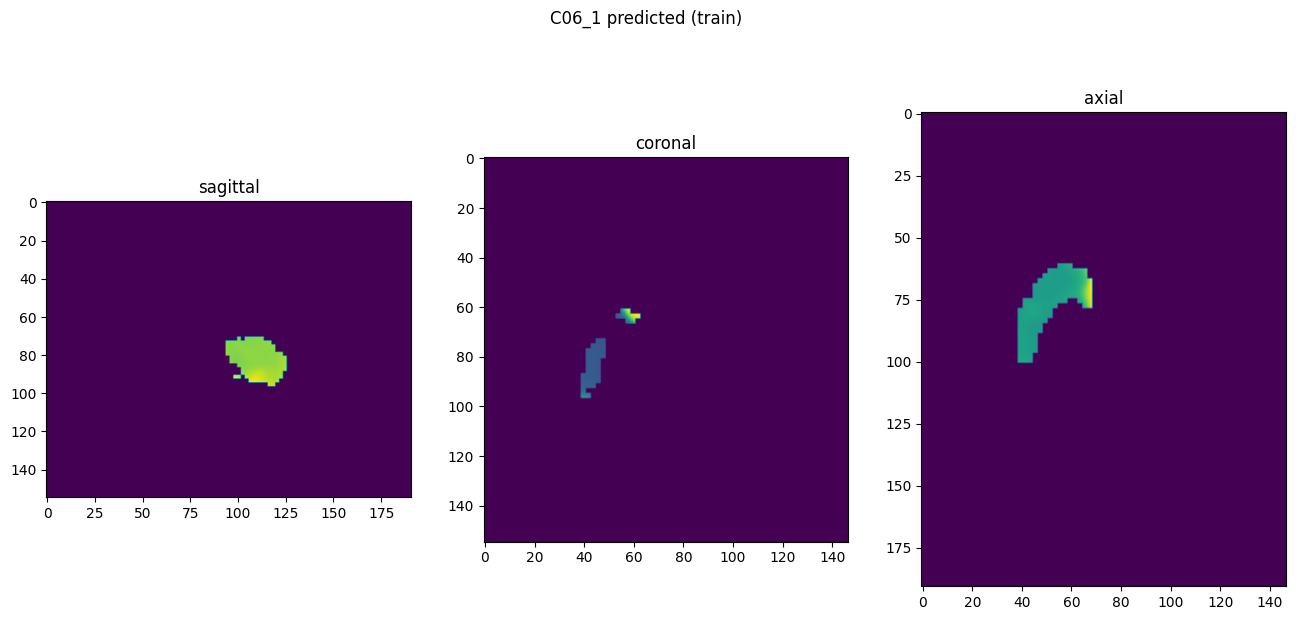

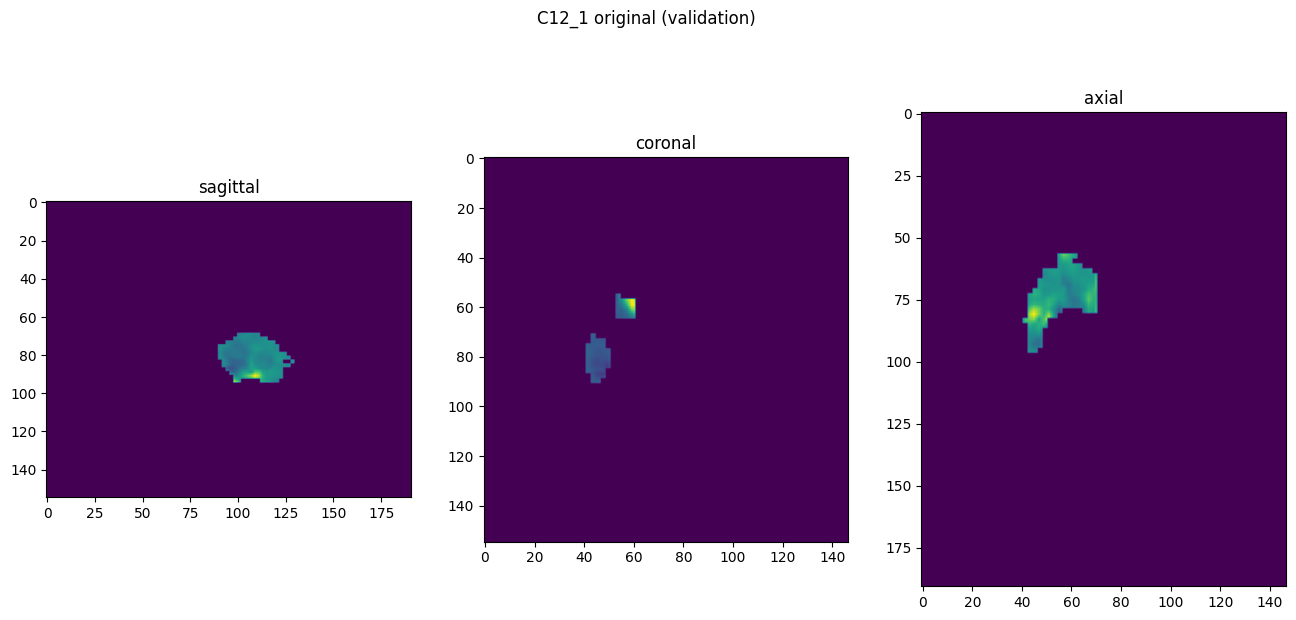

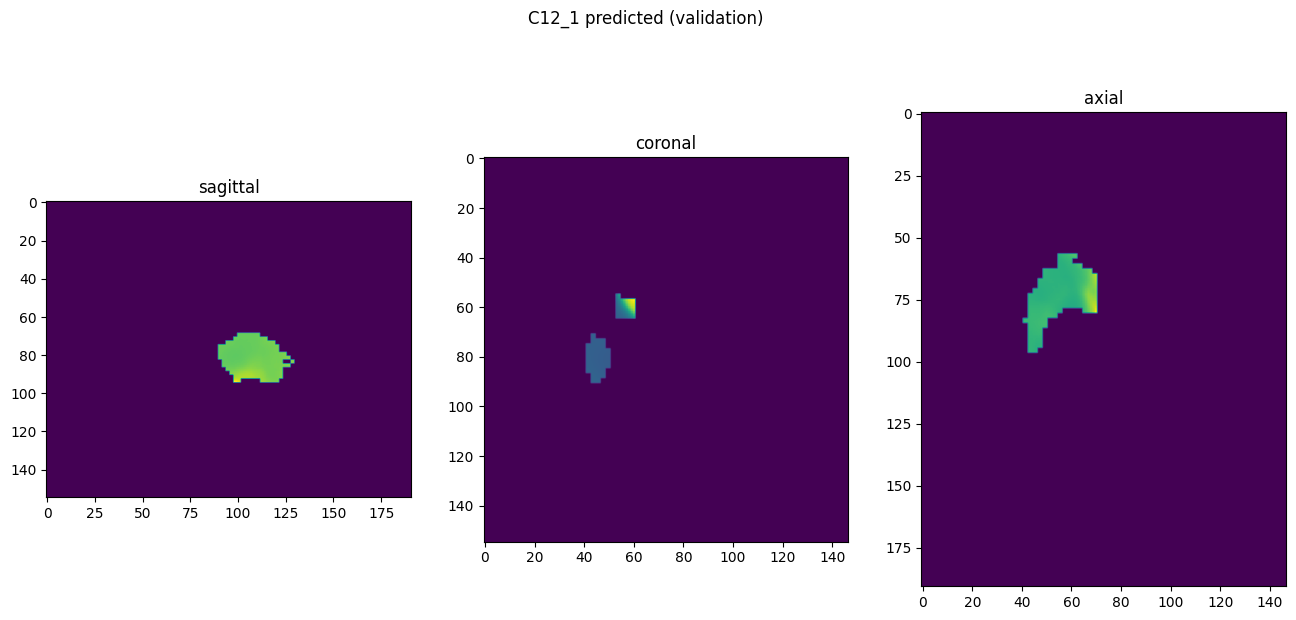

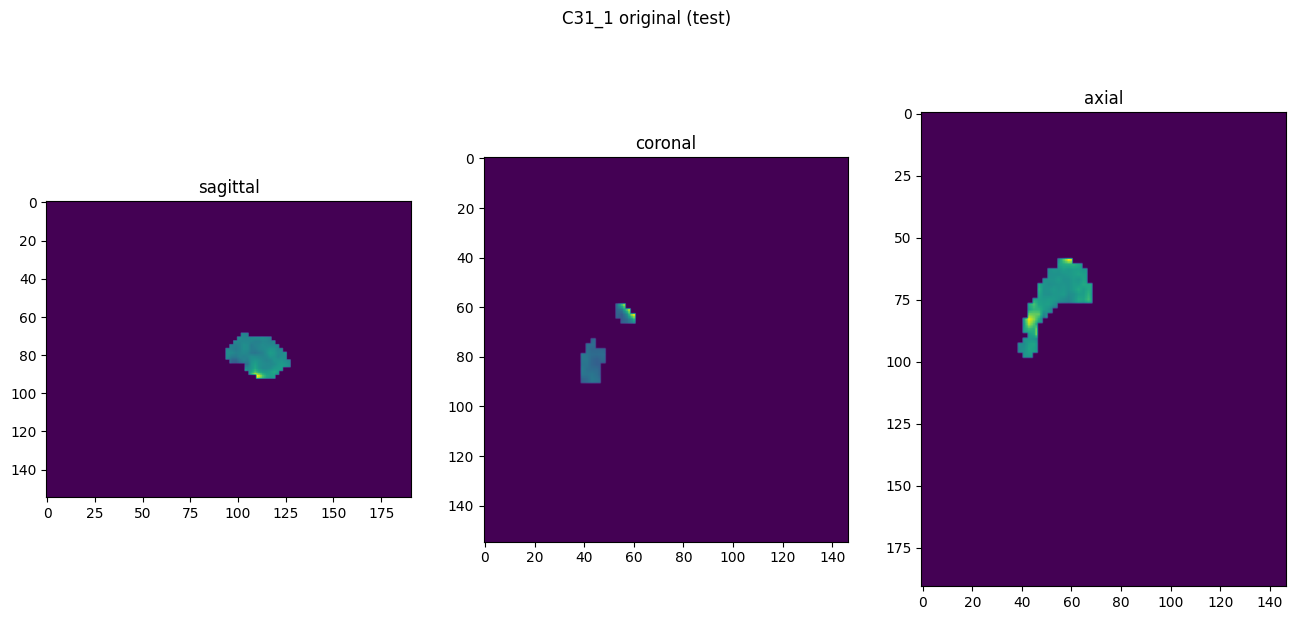

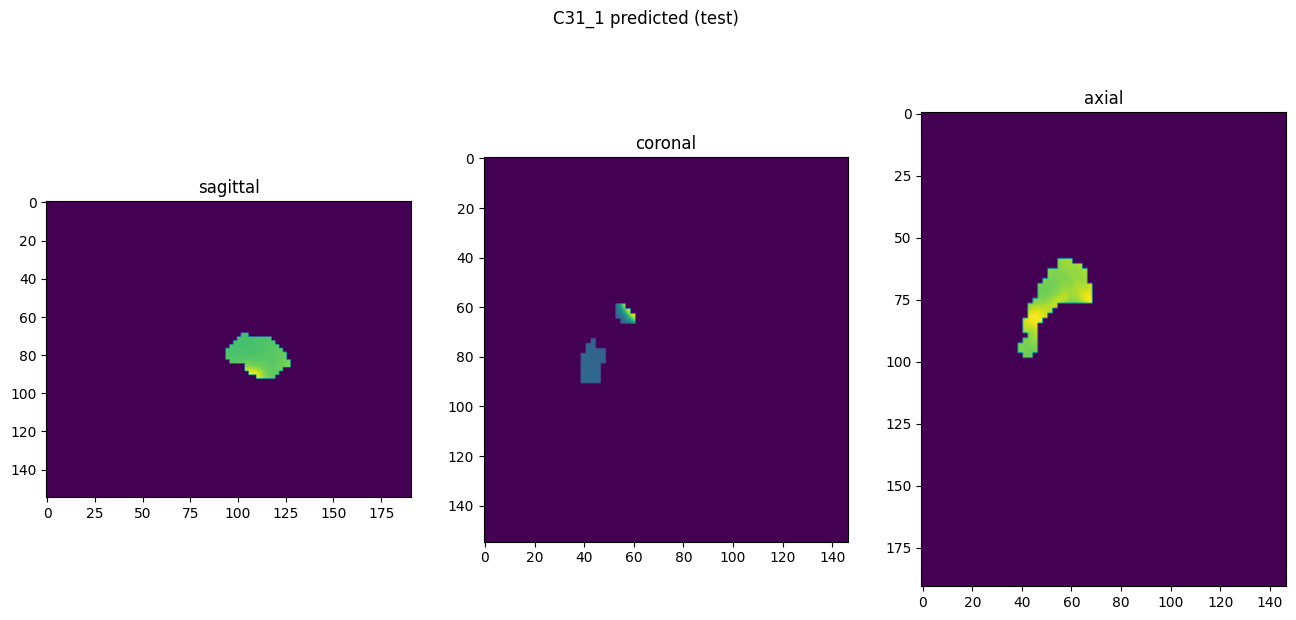

In [10]:
showResults(model, gen, threshold=None, background=False)